In [ ]:
import os
import pandas as pd

In [ ]:
df_0 = pd.read_csv('/content/data-0.csv', sep = ';')

In [ ]:
df_0.shape

(120, 9)

In [ ]:
df_0.head()

,claudius_cat,claudius_sp1,claudius_sp2,tanya_cat,tanya_sp1,tanya_sp2,lena_cat,lena_sp1,lena_sp2
0,DEF,45.0,63.0,NaN,NaN,NaN,DEF,45.0,63.0
1,DEN,119.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN
2,ASS,359.0,395.0,NaN,NaN,NaN,NaN,NaN,NaN
3,DEN,454.0,475.0,DEN,460.0,475.0,NaN,NaN,NaN
4,REL,479.0,488.0,REL,479.0,481.0,NaN,NaN,NaN


In [ ]:
df = df_0.copy()

1. Alle Zeilen, in denen nur ein Eintrag eines Annotators ist, werden entfernt:

In [ ]:
annotators = ['claudius_cat', 'tanya_cat', 'lena_cat']

# Count the number of non-empty 'cat' columns for each row
non_empty_counts = df_0[annotators].count(axis=1)

# Keep only the rows with two or more non-empty 'cat' columns
df_filtered = df_0[non_empty_counts >= 2]

In [ ]:
df.shape

(120, 9)

2. Funktion: Dataframe wird verändert
- 4 Spalten: Name, Label, Spananfang, Spanende
- insgesamt dann 4x3 = 12 Spalten?

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
# Assuming your DataFrame is named df
# Replace NaN with a placeholder value (e.g., "UNKNOWN") for handling missing values
#df.fillna("UNKNOWN", inplace=True)
def filter_disagreement(df):
    # Identify rows where at least two annotators agree
    df['majority_agree'] = df[['claudius_cat', 'tanya_cat', 'lena_cat']].apply(lambda row: len(set(row)) < 3, axis=1)

    df.loc[df['majority_agree'], 'final_category'] = df[df['majority_agree']].apply(
        lambda row: Counter(row.filter(like='_cat')).most_common(1)[0][0],
        axis=1
    )
    return df[df['majority_agree'] == True]

In [ ]:
# Assuming your DataFrame is named df
import pandas as pd
def reconfigurate_df (df):
    # List of annotators and their corresponding 'cat' columns
    annotators = ['claudius_cat', 'tanya_cat', 'lena_cat']

    # Create a new DataFrame to store the results
    new_df = pd.DataFrame()

    # Iterate over each annotator
    for annotator in annotators:
        # Extract annotator name and label from the column names
        annotator_name, label = annotator.split('_')
        df = df.rename(columns={'lena_sp_1': 'lena_sp1'})
        # Create a new DataFrame with 'annotator_name' and 'label' columns
        temp_df = pd.DataFrame({
            'annotator_name': annotator_name,
            'label': df[annotator],
            'sp_1': df[annotator_name + '_sp1'],
            'sp_2': df[annotator_name + '_sp2']

        })

        # Append the new DataFrame to the result DataFrame
        new_df = pd.concat([new_df, temp_df], ignore_index=True)

    # Display the resulting DataFrame
    return new_df


In [ ]:
new_df = reconfigurate_df(df_0)

In [ ]:
new_df

,annotator_name,label,sp_1,sp_2
0,claudius,DEF,45.0,63.0
1,claudius,DEN,119.0,140.0
2,claudius,ASS,359.0,395.0
3,claudius,DEN,454.0,475.0
4,claudius,REL,479.0,488.0
...,...,...,...,...
355,lena,PROP,4399.0,4412.0
356,lena,NaN,NaN,NaN
357,lena,EVA,4451.0,4491.0
358,lena,NaN,NaN,NaN


In [ ]:
!pip install krippendorff

3. Funktion: Werte für Krippendorff's alpha
- meint observed_alpha = observed disagreement?
- meint expected_alpha = expected disagreement?
- wieso nehmen wir für expected_alpha 3 Kategorien an?

In [ ]:
from krippendorff import alpha


def calculate_observed_and_expected_alpha(new_df):
    new_df['label'] = new_df['label'].astype('category').cat.codes
    new_df['annotator_name'] = new_df['annotator_name'].astype('category').cat.codes

    # Remove rows where all annotator columns are missing
    df_filtered = new_df.dropna(subset=['sp_1', 'sp_2'], how='all')

    # Reshape the DataFrame to wide format
    df_wide = df_filtered.pivot_table(index=['label', 'annotator_name'], columns=None, values=['sp_1', 'sp_2'], aggfunc='first').reset_index()

    # Flatten the MultiIndex columns
    df_wide.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in df_wide.columns]

    # Calculate observed Krippendorff's alpha
    observed_alpha = alpha(df_wide.values) # = Krippendorff's alpha

    # Calculate expected Krippendorff's alpha based on a random distribution
    random_data = np.random.randint(0, high=3, size=df_wide.shape)  # Assuming 3 categories
    expected_alpha = alpha(random_data) #

    return observed_alpha, expected_alpha



4. Funktion: Durchschnitt der Cohen's kappa Werte für jedes Label für alle drei berechnen

In [ ]:
import pandas as pd

def get_cohen_kappa(df):

    # Rename the columns
    #data_big.rename(columns={0: "Annotator", 1: "Label", 2: "Start", 3: "End"}, inplace=True)
    average_agreements = {}
    # Group annotations by label
    grouped_labels = df.groupby("label")

    # Calculate percentage agreement for labels
    for label, group in grouped_labels:
        annotator_labels = group.groupby("annotator_name")["label"].apply(list)
        annotator_names = annotator_labels.index.tolist()
        annotator_label_lists = annotator_labels.tolist()

        agreements = []
        for i, annotator1 in enumerate(annotator_label_lists):
            for j, annotator2 in enumerate(annotator_label_lists[i+1:], start=i+1):
                agreement = sum(1 for a, b in zip(annotator1, annotator2) if a == b) / len(annotator1)
                agreements.append(agreement)
                print(f"Agreement between {annotator_names[i]} and {annotator_names[j]} for label '{label}': {agreement:.2f}")
        try:
            average_agreement = sum(agreements) / len(agreements)
            try:
                average_agreements[label].append(average_agreement)
            except KeyError:
                average_agreements[label] = average_agreement
        except ZeroDivisionError:
            pass
        print(f"Average Agreement for label '{label}': {average_agreement:.2f}")
        print()
    return average_agreements


5. Anwendung Cohen's kappa Funktion für alle Zeilen, in denen von mind. zwei Annotatoren label sind.
*   big_df?
*   aussagekräftig?



In [ ]:
import pandas as pd
import glob
import numpy as np
# Specify the directory containing your CSV files
directory_path = '/content/*.csv'

# Use glob to get a list of file paths that match the pattern
file_paths = glob.glob(directory_path)
agreements = []
krippendorfs = {}
annotators = ['claudius_cat', 'tanya_cat', 'lena_cat']
big_df = pd.DataFrame()
for file_path in file_paths:
    df = pd.read_csv(file_path, sep =';')
    big_df = pd.concat([big_df, df], ignore_index = True)

    # Count the number of non-empty 'cat' columns for each row
    non_empty_counts = df[annotators].count(axis=1)
    # Keep only the rows with two or more non-empty 'cat' columns
    df = df[non_empty_counts >= 2]
    df = reconfigurate_df(df)
    agreements.append(get_cohen_kappa(df))
print(big_df.shape)
non_empty_counts_big = big_df[annotators].count(axis=1)
big_df = big_df[non_empty_counts_big>=2]
print(big_df.shape)

Agreement between lena and tanya for label 'ASS': 1.00
Average Agreement for label 'ASS': 1.00

Average Agreement for label 'DEN': 1.00

Agreement between claudius and lena for label 'EVA': 1.00
Agreement between claudius and tanya for label 'EVA': 1.00
Agreement between lena and tanya for label 'EVA': 1.00
Average Agreement for label 'EVA': 1.00

Agreement between claudius and lena for label 'PROP': 1.00
Agreement between claudius and tanya for label 'PROP': 0.50
Agreement between lena and tanya for label 'PROP': 0.33
Average Agreement for label 'PROP': 0.61

Agreement between claudius and lena for label 'REL': 1.00
Agreement between claudius and tanya for label 'REL': 1.00
Agreement between lena and tanya for label 'REL': 1.00
Average Agreement for label 'REL': 1.00

Agreement between claudius and lena for label 'ANEC': 0.90
Agreement between claudius and tanya for label 'ANEC': 1.00
Agreement between lena and tanya for label 'ANEC': 1.00
Average Agreement for label 'ANEC': 0.97

Agr

6. Anwendung Krippendorff's alpha Funktion
*   nur Zeilen, in denen mindestens zwei Annotatoren Einträge haben
*   Woher kommt Funktion 'calculate_observed_and_expected_alpha?
*   (ist nicht "alpha", sondern "disagreement"?!)



In [ ]:
import pandas as pd
import glob
import numpy as np
# Specify the directory containing your CSV files
directory_path = '/content/*.csv'

# Use glob to get a list of file paths that match the pattern
file_paths = glob.glob(directory_path)
krippendorfs = {}
annotators = ['claudius_cat', 'tanya_cat', 'lena_cat']
big_df = pd.DataFrame()
for file_path in file_paths:
    df = pd.read_csv(file_path, sep =';')
    big_df = pd.concat([big_df, df], ignore_index = True)

    # Count the number of non-empty 'cat' columns for each row
    non_empty_counts = df[annotators].count(axis=1)
    # Keep only the rows with two or more non-empty 'cat' columns
    df = df[non_empty_counts >= 2]
    df = reconfigurate_df(df)
    krippendorfs[file_path] = calculate_observed_and_expected_alpha(df)

print(krippendorfs)

{'/content/data-9.csv': (0.4746742895341164, -0.04569377990430645), '/content/data-5.csv': (0.167883592158674, -0.019100158333301476), '/content/data-3.csv': (0.1000684957398873, -0.016931724705237183), '/content/data-0.csv': (0.3168555192606426, -0.005174644243208348), '/content/data-7.csv': (0.3040432752165617, 0.0688757086459485), '/content/data-1.csv': (0.31210968415187934, -0.01488353730754044), '/content/data-2.csv': (0.38800171137349915, -0.015221721354439666), '/content/data-6.csv': (0.2527776679238196, 0.036091103047101725), '/content/data-8.csv': (0.3486261728260469, -0.002147791686348599), '/content/data-4.csv': (0.18536119507309112, -0.025580438129792382)}


7. Berechnung vom Durchschnitt der Cohen's kappa Werte? (gespeichert in 'agreement'?)

In [ ]:
# Create a dictionary to store the sum and count for each label
label_sum_count = {}

# Iterate over each dictionary in the list
for d in agreements:
    for label, value in d.items():
        if label not in label_sum_count:
            label_sum_count[label] = {'sum': 0, 'count': 0}
        label_sum_count[label]['sum'] += value
        label_sum_count[label]['count'] += 1

# Calculate the average for each label
label_avg = {label: label_sum_count[label]['sum'] / label_sum_count[label]['count'] for label in label_sum_count}

# Print the average for each label
for label, avg in label_avg.items():
    print(f"Average for '{label}': {avg}")

Average for 'ASS': 0.6820323387304519
Average for 'EVA': 0.8714332873245917
Average for 'PROP': 0.9303632478632478
Average for 'REL': 0.9527777777777778
Average for 'ANEC': 0.7872134038800706
Average for 'AUT': 0.7950391172613396
Average for 'COM': 0.7568342151675486
Average for 'DEF': 0.8917548500881836
Average for 'DEN': 0.8278980278980278
Average for 'SIM': 0.8523815958598568


8.
1.   Funktion: maximale Spanlänge berechnen
2.   Funktion: overlap berechnen
* von zwei Annotatoren?
* was genau zählt als intersection?
3. Anwendung der beiden Funktionen







In [ ]:
import pandas as pd
import glob
from itertools import combinations
import numpy as np

from itertools import combinations

def calculate_max_span_length(row, annotators):
    span_lengths = []

    for annotator in annotators:
        sp_1_col = f'{annotator}_sp1'
        sp_2_col = f'{annotator}_sp2'

        start = row[sp_1_col]
        end = row[sp_2_col]

        # Calculate span length
        span_length = end - start + 1

        # Append to the span lengths list
        span_lengths.append(span_length)

    # Calculate max span length
    max_span_length = max(span_lengths)

    return max_span_length


def calculate_average_overlap(row, annotators):
    overlaps = []

    # Find all combinations of annotators
    annotator_combinations = combinations(annotators, 2)

    for a1, a2 in annotator_combinations:
        sp_1_col_a1 = f'{a1}_sp1'
        sp_2_col_a1 = f'{a1}_sp2'

        sp_1_col_a2 = f'{a2}_sp1'
        sp_2_col_a2 = f'{a2}_sp2'

        start_a1 = row[sp_1_col_a1]
        end_a1 = row[sp_2_col_a1]

        start_a2 = row[sp_1_col_a2]
        end_a2 = row[sp_2_col_a2]

        # Calculate the intersection
        intersection_length = max(0, min(end_a1, end_a2) - max(start_a1, start_a2) + 1)

        # Append to the overlaps list
        overlaps.append(intersection_length)

    # Calculate average overlap
    avg_overlap = np.mean(overlaps)

    return avg_overlap

# Specify the directory containing your CSV files
directory_path = '/content/*.csv'


# Use glob to get a list of file paths that match the pattern
file_paths = glob.glob(directory_path)
file_paths = sorted(file_paths, key=lambda x: int(x.split('-')[-1].split('.')[0]))

# Initialize variables to store results
total_avg_overlap = 0
total_max_span_length = 0

# Iterate through unique categories
annotators = ['claudius', 'tanya', 'lena']
overlap_dfs = []

for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';')
    df = df.rename(columns={'lena_sp_1': 'lena_sp1'})
    annotators_cat = ['claudius_cat', 'tanya_cat', 'lena_cat']

    # Count the number of non-empty 'cat' columns for each row
    non_empty_counts = df[annotators_cat].count(axis=1)

    # Keep only the rows with two or more non-empty 'cat' columns

    df = df[non_empty_counts >= 2]
    print(file_path, df.shape)
    df = filter_disagreement(df)
    print(file_path, df.shape)

    # Calculate average overlap per row
    df['Avg_Overlap'] = df.apply(lambda row: calculate_average_overlap(row, annotators), axis=1)
    df['Max_Span_Length'] = df.apply(lambda row: calculate_max_span_length(row, annotators), axis=1)
    df = df.dropna(subset=['Max_Span_Length'])
    df['Overlap_Percent_of_Max'] = (df['Avg_Overlap'] / df['Max_Span_Length']).round(2)
    df['Overlap_Percent_of_Max'] = df['Overlap_Percent_of_Max'].fillna(0.01)

    # Append to the list of DataFrames
    overlap_dfs.append(df)

    # Update total averages
    total_avg_overlap += df['Overlap_Percent_of_Max'].mean()
    total_max_span_length += df['Max_Span_Length'].mean()

# Calculate average overlap per DataFrame
avg_overlap_per_df = total_avg_overlap / len(overlap_dfs)
avg_max_span_length_per_df = total_max_span_length / len(overlap_dfs)

print(f"Average Overlap per DataFrame: {avg_overlap_per_df}")
print(f"Average Max Span Length per DataFrame: {avg_max_span_length_per_df}")

/content/data-0.csv (56, 9)
/content/data-0.csv (50, 11)
/content/data-1.csv (72, 9)
/content/data-1.csv (54, 11)
/content/data-2.csv (169, 9)
/content/data-2.csv (129, 11)
/content/data-3.csv (164, 9)
/content/data-3.csv (110, 11)
/content/data-4.csv (88, 9)
/content/data-4.csv (63, 11)


<ipython-input-69-1715fac07525>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg_Overlap'] = df.apply(lambda row: calculate_average_overlap(row, annotators), axis=1)
<ipython-input-69-1715fac07525>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Max_Span_Length'] = df.apply(lambda row: calculate_max_span_length(row, annotators), axis=1)
<ipython-input-69-1715fac07525>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

/content/data-5.csv (211, 9)
/content/data-5.csv (163, 11)
/content/data-6.csv (160, 9)
/content/data-6.csv (108, 11)
/content/data-7.csv (89, 9)
/content/data-7.csv (39, 11)
/content/data-8.csv (97, 9)
/content/data-8.csv (77, 11)
/content/data-9.csv (7, 9)
/content/data-9.csv (5, 11)
Average Overlap per DataFrame: 0.7590464659601686
Average Max Span Length per DataFrame: 32.25144678523


In [ ]:
print(f"Average Overlap per DataFrame: {avg_overlap_per_df}")


Average Overlap per DataFrame: 0.7365099690257007


In [ ]:
print(f"Average Max Span Length per DataFrame: {avg_max_span_length_per_df}")

Average Max Span Length per DataFrame: 28.06549832062605


9. Durchschnitt des overlaps - über Annotatoren?

In [ ]:
from statistics import mean
for i in range(len(overlap_dfs)):
    print(i,  "Average overlap", mean(list(overlap_dfs[i].Overlap_Percent_of_Max.values)))
    print(i, 'Average span length',mean(list(overlap_dfs[i].Max_Span_Length.values)))

0 Average overlap 0.6775238095238095
0 Average span length 23.257142857142856
1 Average overlap 0.7482178217821782
1 Average span length 21.88118811881188
2 Average overlap 0.7188095238095238
2 Average span length 35.416666666666664
3 Average overlap 0.6861538461538461
3 Average span length 35.62820512820513
4 Average overlap 0.7540789473684211
4 Average span length 26.986842105263158
5 Average overlap 0.7147311827956989
5 Average span length 33.704301075268816
6 Average overlap 0.7265833333333334
6 Average span length 33.041666666666664
7 Average overlap 0.7576470588235295
7 Average span length 25.84313725490196
8 Average overlap 0.7446875000000001
8 Average span length 33.229166666666664
9 Average overlap 0.8366666666666667
9 Average span length 11.666666666666666


In [ ]:
overlap_dfs[0].columns

Index(['claudius_cat', 'claudius_sp1', 'claudius_sp2', 'tanya_cat',
       'tanya_sp1', 'tanya_sp2', 'lena_cat', 'lena_sp1', 'lena_sp2',
       'Avg_Overlap', 'Max_Span_Length', 'Overlap_Percent_of_Max'],
      dtype='object')

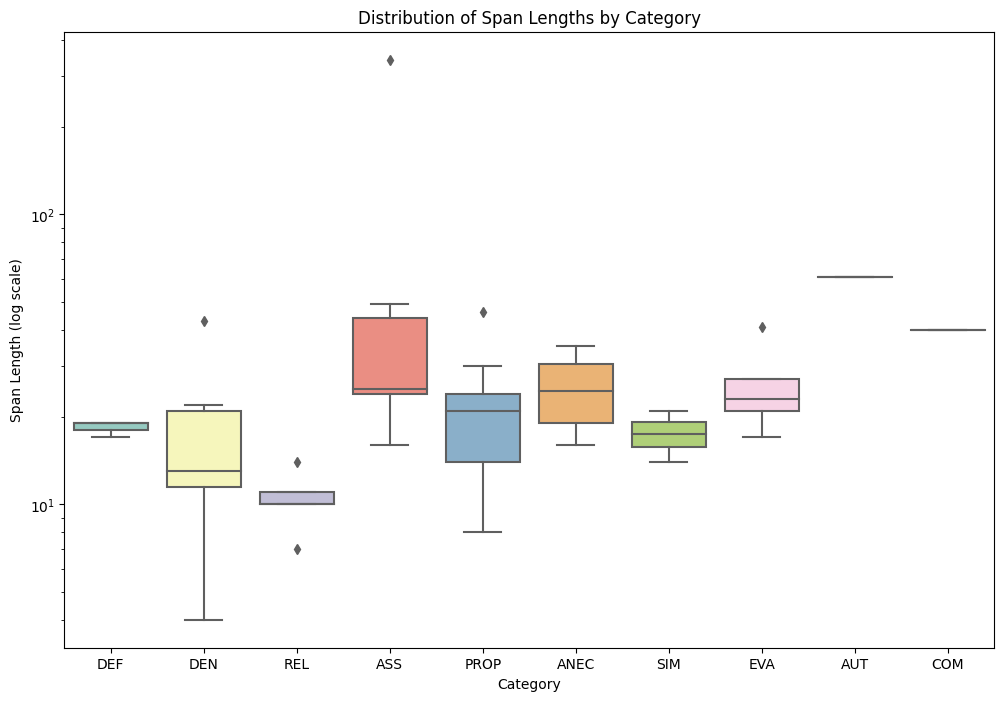

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'span_length' and 'category'
# Replace 'df', 'span_length', and 'category' with your actual DataFrame and column names

plt.figure(figsize=(12, 8))

# Box plot
sns.boxplot(x='final_category', y='Max_Span_Length', data=overlap_dfs[0], palette='Set3')

plt.yscale('log')  # Set the y-axis to a logarithmic scale

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Span Length (log scale)')
plt.title('Distribution of Span Lengths by Category')

# Show the plot
plt.show()

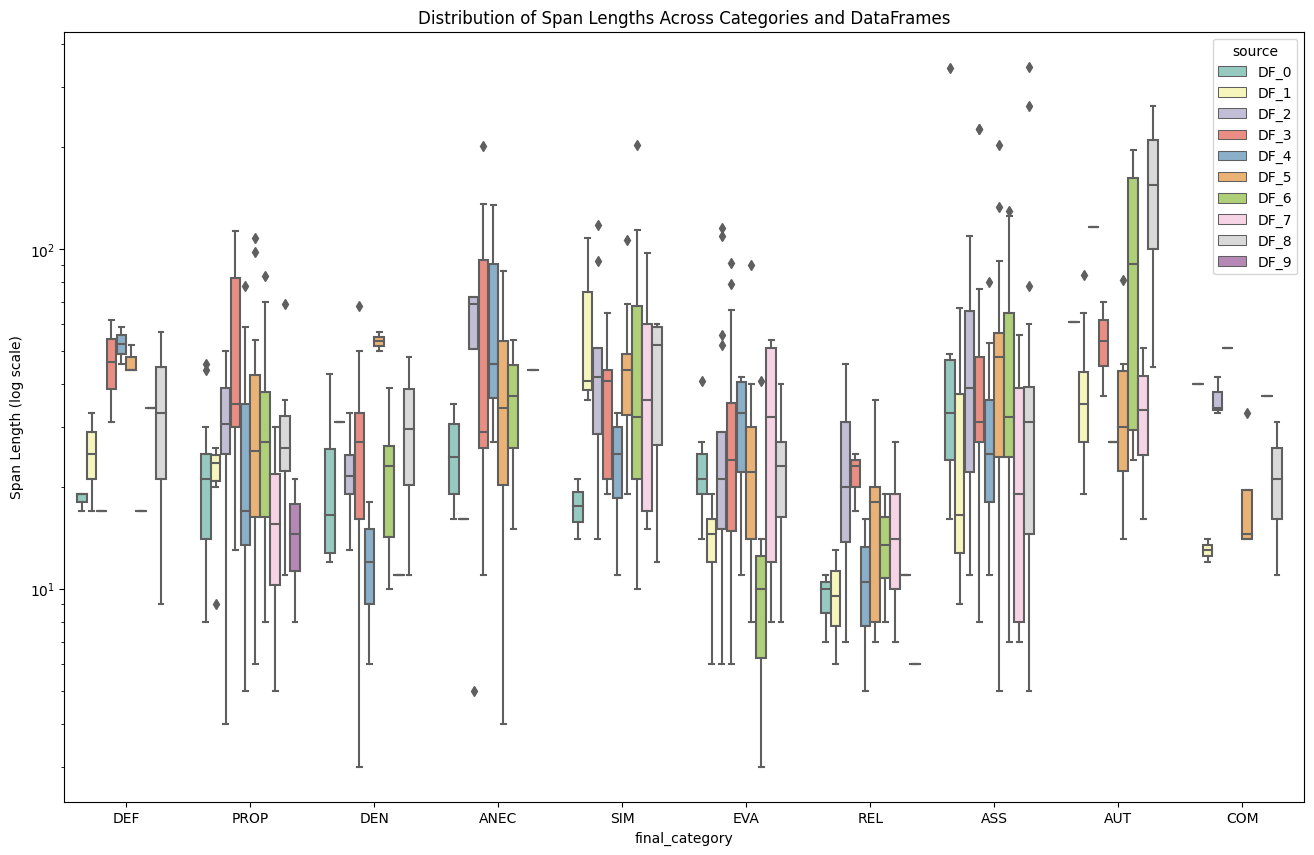

In [ ]:

# Assuming you have a list of DataFrames 'overlap_dfs'
# Replace 'overlap_dfs' with your actual list of DataFrames
# Combine the DataFrames into a single DataFrame with an additional 'source' column
combined_df = pd.concat([df.assign(source=f'DF_{i}') for i, df in enumerate(overlap_dfs)])

plt.figure(figsize=(16, 10))

# Box plot with log scale on y-axis
sns.boxplot(x='lena_cat', y='Max_Span_Length', hue='source', data=combined_df, palette='Set3')
plt.yscale('log')  # Set the y-axis to a logarithmic scale

# Add labels and title
plt.xlabel('final_category')
plt.ylabel('Span Length (log scale)')
plt.title('Distribution of Span Lengths Across Categories and DataFrames')

# Show the plot
plt.show()

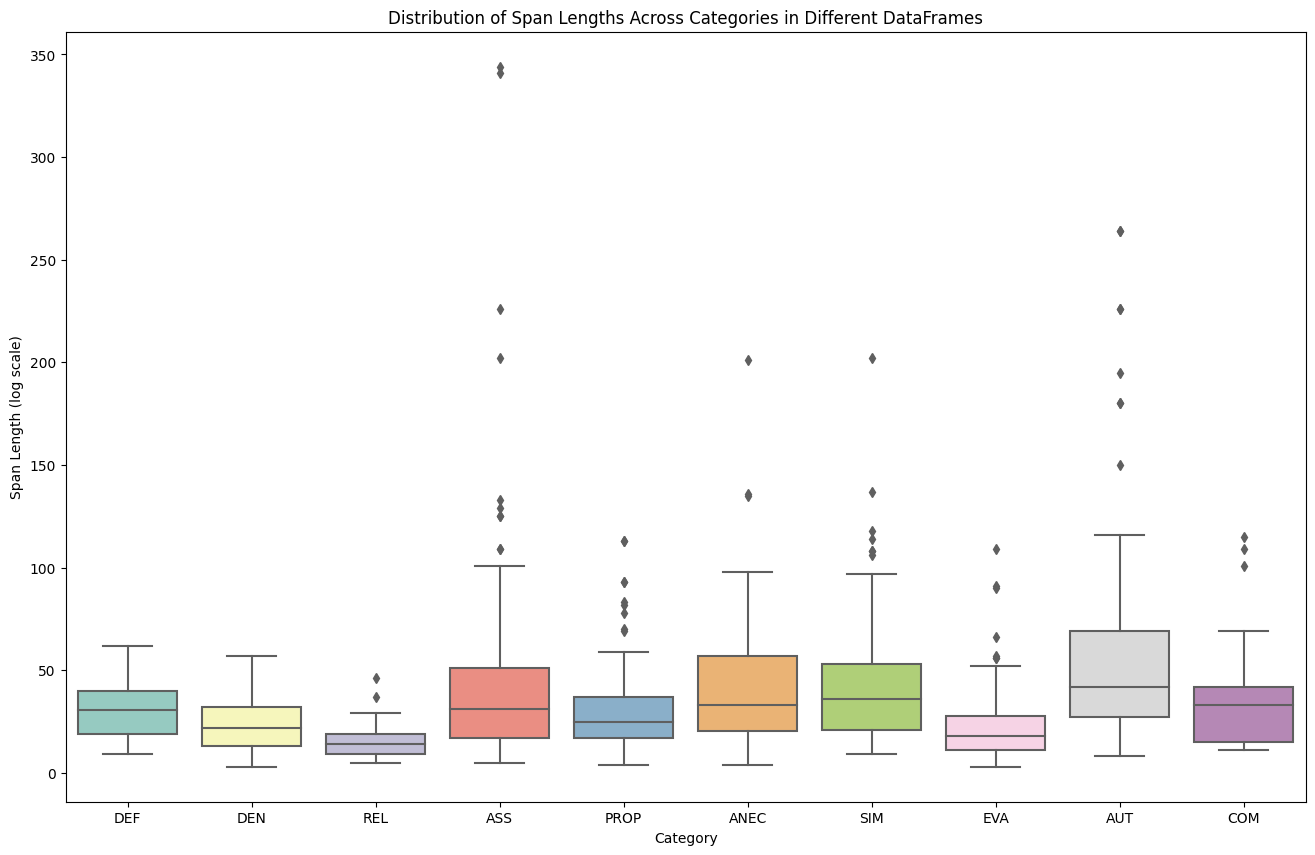

In [ ]:
# Combine the DataFrames into a single DataFrame
combined_df = pd.concat(overlap_dfs)
combined_df.replace("SIMP", "SIM", inplace=True)

plt.figure(figsize=(16, 10))

# Box plot with log scale on y-axis
sns.boxplot(x='final_category', y='Max_Span_Length', data=combined_df, palette='Set3')
#plt.yscale('log')  # Set the y-axis to a logarithmic scale

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Span Length (log scale)')
plt.title('Distribution of Span Lengths Across Categories in Different DataFrames')

# Show the plot
plt.show()

In [ ]:
combined_df['final_category'].value_counts()

ASS     193
PROP    137
EVA     110
SIM      92
AUT      47
DEN      45
ANEC     38
REL      31
COM      29
DEF      22
Name: final_category, dtype: int64

10. Visualisierung der durschnittlichen Überlappung und Spanlänge



In [ ]:
def visualize_metrics(overlap_dfs):
    avg_overlaps = []
    max_span_lengths = []
    df_indices = [f'DF {i}' for i in range(1, len(overlap_dfs) + 1)]

    for df in overlap_dfs:
        avg_overlap = df['Avg_Overlap'].mean()
        max_span_length = df['Max_Span_Length'].mean()

        avg_overlaps.append(avg_overlap)
        max_span_lengths.append(max_span_length)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35

    bar1 = ax.bar(df_indices, avg_overlaps, bar_width, label='Average Overlap')
    bar2 = ax.bar([i + bar_width for i in range(len(df_indices))], max_span_lengths, bar_width, label='Average Max Span Length')

    ax.set_xlabel('DataFrame Index')
    ax.set_ylabel('Metric Value')
    ax.set_title('Average Overlap and Max Span Length per DataFrame')
    ax.set_xticks([i + bar_width / 2 for i in range(len(df_indices))])
    ax.set_xticklabels(df_indices)
    ax.legend()

    plt.show()

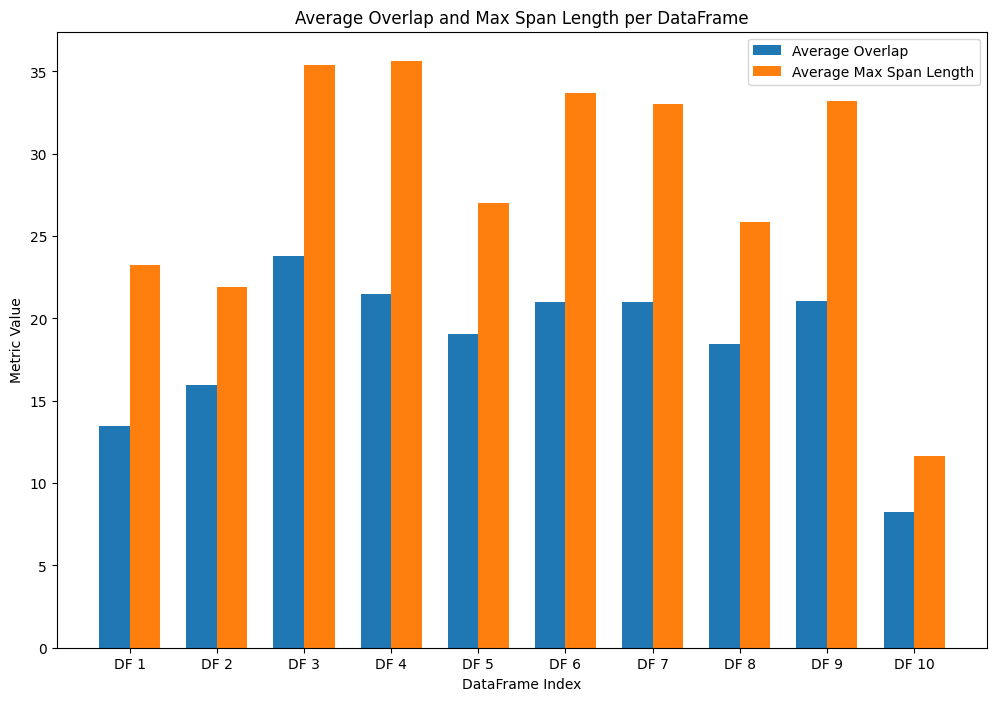

In [ ]:
import matplotlib.pyplot as plt

visualize_metrics(overlap_dfs)